In [8]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from scipy import ndimage
from func import *
from astropy.table import Table, hstack
import os
import glob
from astropy.table import Table, vstack, join
import pandas as pd
from shutil import copyfile


In [9]:
def scale_factor_spectrum(z,data,error,wo_wave):
    k = 1+z
    select1 = (wo_wave>6750*k) & (wo_wave<6800*k)
    cont_dat = data[select1]
    cont_err = error[select1]
    error_maincube = np.std(cont_dat)
    error_errcube = np.mean(cont_err)
    fact = error_maincube/error_errcube
    return fact


In [10]:
def popt_central_fit(wo_wave,data,error,obj,p_init,z,broad2=False):
    k = 1+z
    select = (wo_wave>4750*k) & (wo_wave<5090*k)
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1
    popt_full_fit,pcov_full_fit = leastsq(full_gauss,x0=p_init,args=(wo_wave[select],data[select],error[select]),maxfev = 10000000)
    v_out = [popt_full_fit[2] - popt_full_fit[6]]
    parameters = np.append(popt_full_fit,v_out)
    Monte_Carlo_loops = 100
    parameters_MC = np.zeros((len(parameters),Monte_Carlo_loops))
    for l in range(Monte_Carlo_loops):
        iteration_data = np.random.normal(data[select],error[select]) 
        popt_MC,pcov_MC =leastsq(full_gauss,x0=p_init,args=(wo_wave[select],iteration_data,error[select]),maxfev = 10000000)
        v_out_MC = [popt_MC[2] - popt_MC[6]]
        par_MC = np.append(popt_MC,v_out_MC)
        parameters_MC[:,l]=par_MC
    parameters_err = np.std(parameters_MC,1)  
    (amp_Hb_error,amp_OIII5007_error,vel_OIII_error,vel_sigma_OIII_error,amp_Hb_br_error,amp_OIII5007_br_error,vel_OIII_br_error,vel_sigma_OIII_br_error,amp_Hb1_error,amp_Fe5018_1_error,vel_Hb1_error,vel_sigma_Hb1_error,amp_Hb2_error,amp_Fe5018_2_error,vel_Hb2_error,vel_sigma_Hb2_error,m_error,c_error,v_out_error) = parameters_err
    return parameters,parameters_err 

In [11]:
def plot(obj,wo_wave,data,error,z,popt_full_fit,broad2=False,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    (amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit,v_out_fit) = popt_full_fit
    par_full_fit = [amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit]
    k = 1+z
    select = (wo_wave>4750*k) & (wo_wave < 5090*k)
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1

    fit = full_gauss(par_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
    residual = data[select] - fit
    
    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(wo_wave[select],data[select],color='black',label='data',drawstyle='steps-mid',lw = 3)
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)",fontsize=15)
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_data.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
    plt.show()
    
    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(wo_wave[select],data[select],color='gray',label='data',drawstyle='steps-mid',lw = 3)
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label='core')
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='wing')
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=15)
    plt.legend(fontsize=15)
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_NLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
    plt.show()
    
    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(wo_wave[select],data[select],color='gray',label='data',drawstyle='steps-mid',lw = 3)
    plt.plot(wo_wave[select],Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit) + Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='purple',linestyle='--',label='BLR')
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=15)
    plt.legend(fontsize=15)
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_BLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
    plt.show()

    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(wo_wave[select],data[select],'r-',label='data',drawstyle='steps-mid',linewidth=3,color='gray')
    plt.plot(wo_wave[select],fit,'r:',label='fit')
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label='core')
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='wing',linestyle='-.')
    plt.plot(wo_wave[select],Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit) + Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='purple',linestyle='-.',label='BLR')
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=20)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=15)
    plt.legend(fontsize=15)
    plt.show()     
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_components.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)

    fig = plt.gcf()
    fig.set_size_inches(9, 3)
    plt.plot(wo_wave[select],residual/error[select],drawstyle='steps-mid',color='black')
    plt.axhline(y=0.0, color='r', linestyle='--')
    #plt.title('%s_brightest_pixel_fit'%(obj))
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=20)
    plt.ylabel(r"Residual/Error",fontsize=15)
    plt.legend(fontsize=15)
    plt.show()     
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_residual.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)


In [12]:
def central_table(obj,popt_full_fit,brightest_pixel_x,brightest_pixel_y,parameters_err,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    central_coordinates = [int(brightest_pixel_x),int(brightest_pixel_y)]
    #print central_coordinates
    popt = np.append(popt_full_fit,central_coordinates)
    central_cordinates_err = [0,0]
    err = np.append(parameters_err,central_cordinates_err)
    column_names={'amp_Hb':0,'amp_OIII5007':1,'vel_OIII':2,'vel_sigma_OIII':3,'amp_Hb_br':4,'amp_OIII5007_br':5,'vel_OIII_br':6,
              'vel_sigma_OIII_br':7,'amp_Hb1':8,'amp_Fe5018_1':9,'vel_Hb1':10,'vel_sigma_Hb1':11,'amp_Hb2':12,
              'amp_Fe5018_2':13,'vel_Hb2':14,'vel_sigma_Hb2':15,'m':16,'c':17,'v_outflow':18,'central_x':19,'central_y':20}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[popt[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_central_fit.fits'%(destination_path_cube,obj,obj),overwrite=True)

def source_central_tab(obj,z,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_central_fit.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_agncentral_fit.fits'%(destination_path_cube,obj,obj),overwrite=True)


In [13]:
def algorithm_script(obj,p_init,z,broad2,prefix_path_cube="/home/mainak/ftp.hidrive.strato.com/users/login-carsftp/IFU_data",destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    print ('%s'%(obj))
    (wo_cube,wo_err,wo_wave,wo_header) = loadCube('%s/%s/%s.wo_absorption.fits'%(destination_path_cube,obj,obj)) 
    [x0,y0] = agn_location(obj)
    [brightest_pixel_x,brightest_pixel_y] = [int(x0),int(y0)]
    #print brightest_pixel_x,brightest_pixel_y
    (data,error) = (wo_cube[:,brightest_pixel_y,brightest_pixel_x],wo_err[:,brightest_pixel_y,brightest_pixel_x])
    factor = scale_factor_spectrum(z,data,error,wo_wave)
    #print (factor)
    error = factor*error
    #print (~np.isnan(error)).sum(0)
    (popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,obj,p_init,z,broad2)
    print (popt_full_fit,parameters_err)
    plot(obj,wo_wave,data,error,z,popt_full_fit,broad2)
    central_table(obj,popt_full_fit,brightest_pixel_x,brightest_pixel_y,parameters_err)
    source_central_tab(obj,z)


In [ ]:
## z = {"HE0021-1810":0.05352,"HE0021-1819":0.053197,"HE0040-1105":0.041692,"HE0108-4743":0.02392,"HE0114-0015":0.04560
    ,"HE0119-0118":0.054341,"HE0212-0059":0.026385,"HE0224-2834":0.059800,"HE0227-0913":0.016451,"HE0232-0900":0.043143
    ,"HE0253-1641":0.031588,"HE0345+0056":0.031,"HE0351+0240":0.036,"HE0412-0803":0.038160,"HE0429-0247":0.042009
    ,"HE0433-1028":0.035550,"HE0853+0102":0.052,"HE0934+0119":0.050338,"HE1011-0403":0.058314,"HE1017-0305":0.049986
    ,"HE1029-1831":0.040261,"HE1107-0813":0.058,"HE1108-2813":0.024013,"HE1126-0407":0.061960,"HE1237-0504":0.009
    ,"HE1248-1356":0.01465,"HE1330-1013":0.022145,"HE1353-1917":0.035021,"HE1417-0909":0.044,"HE2128-0221":0.05248
    ,"HE2211-3903":0.039714,"HE2222-0026":0.059114,"HE2233+0124":0.056482,"HE2302-0857":0.046860}

objs = z.keys()

broad2= {'HE0021-1810':False,'HE0021-1819':False,'HE0040-1105':False,'HE0108-4743':True,'HE0114-0015':False
        ,'HE0119-0118':True,'HE0212-0059':True,'HE0224-2834':False,'HE0227-0913':True,'HE0232-0900':False
        ,'HE0253-1641':True,'HE0345+0056':True,'HE0351+0240':True,'HE0412-0803':False,'HE0429-0247':True
        ,'HE0433-1028':True,'HE0853+0102':True,'HE0934+0119':True,'HE1011-0403':True,'HE1017-0305':False
        ,'HE1029-1831':True,'HE1107-0813':True,'HE1108-2813':False,'HE1126-0407':True,'HE1237-0504':False
        ,'HE1248-1356':False,'HE1330-1013':True,'HE1353-1917':True,'HE1417-0909':False,'HE2128-0221':False
        ,'HE2211-3903':False,'HE2222-0026':True,'HE2233+0124':True,'HE2302-0857':True}

p_init= {'HE0021-1810':[0.1,1.5248,16056,50.0,1.0,3.0,15956,100.0,1.0,1.0,16056,2000.0,0.0,0.0,16056,3000.0,-0.001,2.0]
        ,'HE0021-1819':[1,12.5,15959,50.0,3,3,15759,200.0,2,2,15959,1000.0,0,0,15959,1000.0,-0.001,0.1]
        ,'HE0040-1105':[1.139,1.5,12507.0,50.0,1.0,3.0,12307.0,200.0,1.0,1.0,12507,1000.0,0,0,12507,1000.0,-0.001,2.0]
        ,'HE0108-4743':[1.7,4.5,7160.0,40.0,0.12,2.5,7100.0,120.0,1.0,1.0,6960,1300.0,1.0,1.0,7190,430.0,-0.001,2.0]
        ,'HE0114-0015':[0.1,1.5,13680,50.0,1.0,3.0,13480,100.0,1.0,1.0,13680,1000.0,0,0,13680,1000.0,-0.001,0.3]
        ,'HE0119-0118':[1,12.5,16302,50.0,3,3,16102,100.0,2,2,16302,1000.0,1,1,16302,2500.0,-0.001,0.1]
        ,'HE0212-0059':[0.1,1.0,7930,170.0,0.1,0.1,7630,450.0,1.0,1.0,7620,4000.0,0.1,0.1,4650,1090.0,-0.001,2.0]
        ,'HE0224-2834':[0.2,2.5,17940,50.0,0.3,0.3,17640,200.0,0.1,0.1,17940,1500.0,0,0,17940,1500.0,-0.001,0.1]
        ,'HE0227-0913':[3,6,4785,150,2,7,4385,300.0,7,1.8,4935,400.0,3,0.5,4735,1500.0,-0.3,4.7]
        ,'HE0232-0900':[2,40,12942,50.0,5,5,12742,100.0,5,1,12942,1000.0,0,0,12942,1000.0,-0.001,0.1]                                     
        ,'HE0253-1641':[2,10,9476,110.0,1,6,9176,370.0,1,1,9476,1500.0,0.5,0.5,9476,550.0,-0.001,0.5]
        ,'HE0345+0056':[0.5,20,9300,150,5,10,9000,300,9,1.8,9300,400,30,2.5,9300,1500,0.3,7.1]
        ,'HE0351+0240':[2.2,37,10600,77,1.1,1.5,10618,277,1.5,0.07,11580,320,3,0.35,10650,1344,-0.3,3]                                                    
        ,'HE0412-0803':[1.139,1.5,11448,50.0,0.1,0.3,11248,100.0,0.1,0.1,11448,1000.0,0,0,11448,1000.0,-0.001,0.5]
        ,'HE0429-0247':[0.9,8.5,12600,90,0.2,2.0,12500,220,1.7,0.07,12600,450,1.3,0.2,12600,1600,-0.5,4.0]
        ,'HE0433-1028':[0.9,4.0,10665.0,100.0,1.0,1.0,10465.0,300.0,1.0,1.0,10665,800.0,0.1,0.1,10665,1500.0,-0.1,1.0]
        ,'HE0853+0102':[0.1,0.9,15700,110.0,0.02,0.3,15670,320.0,0.1,0.1,15900,1640.0,0.0,0.0,17250,810.0,-0.001,0.1]
        ,'HE0934+0119':[0.6,1.9,15101,100.0,0.2,0.2,14901,400.0,0.3,0.1,15101,1000.0,0.1,0.1,15101,1000.0,0.001,0.7]
        ,'HE1011-0403':[0.1,0.6,17494,60.0,0.2,0.2,17244,200.0,0.3,0.1,17494,1500.0,0.1,0.1,17494,1500.0,0.001,0.7]
        ,'HE1017-0305':[0.1,1.5,14695,50,0.08,0.4,14595,200,0.7,0.09,14695,2000,0,0,0,0,-0.3,2.0]
        ,'HE1029-1831':[0.6,1.3,12114,50.0,0.2,0.2,11978,200.0,0.3,0.1,12114,1000.0,0.2,0.2,12114,1000.0,-0.001,0.2]
        ,'HE1107-0813':[0.04,0.3,17500,100,0.2,0.13,17400,480,0.9,0.13,17500,1000,0.9,0.08,16800,2000,-0.9,8]
        ,'HE1108-2813':[1.139,1.5,7200.0,50.0,1.0,3.0,7000.0,100.0,1.0,1.0,7200,1000.0,0,0,7200,1000.0,-0.001,2.0]
        ,'HE1126-0407':[1,13,18200,100,2.5,3,18000,300,10,1.3,18200,800,7,1.8,18200,1600,-0.9,15]
        ,'HE1237-0504':[1,10,2700.0,80.0,0.5,2,2700.0,200,2,0.5,2700.0,1500.0,0,0,2700.0,1000.0,-0.001,0.002]
        ,'HE1248-1356':[0.1,1.5,4395.0,50.0,1.0,3.0,4195.0,100.0,1.0,1.0,4395,1000.0,0,0,0,0.0,-0.001,2.0]
        ,'HE1330-1013':[0.15,0.6,6643,90,0.05,0.15,6543,200,0.12,0.04,6643,1500,0.3,0.04,6643,500,-0.02,0.3]
        ,'HE1353-1917':[0.07,0.7,10490.0,80.0,0.39,0.05,10306.0,490.0,0.1,0.02,8600.0,1500.0,0.14,0.02,12326.0,1500.0,-0.001,0.002]
        ,'HE1417-0909':[1,12.5,13200,50.0,3,3,13000,100.0,2,2,13200,1000.0,0,0,13200,1000.0,-0.001,0.1]
        ,'HE2128-0221':[0.1,1.5,15744,50.0,1.0,3.0,15544,100.0,1.0,1.0,15744,1000.0,0,0,15744,1000.0,-0.001,2.0]
        ,'HE2211-3903':[0.6,2.4,11914,50.0,0.1,0.1,11714,100.0,0.1,0.1,11914,200.0,0,0,11914,100.0,-0.001,0.2]
        ,'HE2222-0026':[0.08,0.4,17400.0,140.0,0.04,0.05,17150.0,300.0,0.4,0.1,18500,650.0,0.02,0.01,17460,1750.0,-0.001,0.002]
        ,'HE2233+0124':[0.1,1.2,16944.0,100.0,1.0,3.0,17044.0,300.0,1.0,1.0,16944,1200.0,1.0,1.0,16944,4000.0,-0.001,2.0]
        ,'HE2302-0857':[1,8,14058,200,0.1,2,14258,300,1,0.1,14058,1000,0.1,0.1,14058,1000,0.01,0.2]}

for obj in objs:
     algorithm_script(obj,p_init[obj],z[obj],broad2[obj]) 


HE0108-4743
[ 2.83375208e-01  6.15926704e-01  7.16269389e+03  4.43508920e+01
  4.64603681e-02  4.95456012e-01  7.10179269e+03  1.20167260e+02
  4.35044677e-02  5.72583486e-03  7.05569986e+03  1.76750133e+03
  2.17338769e-01  3.91077566e-02  7.16977479e+03  5.11371720e+02
 -2.12300323e-02  2.81753691e-01  6.09012009e+01] [2.79812329e-02 9.74310557e-02 4.78443001e+00 1.20102112e+01
 2.99182775e-02 1.00122480e-01 1.10932216e+01 8.69675714e+00
 9.39726359e-03 2.69694019e-03 1.22082675e+02 2.12696694e+02
 9.89292771e-03 2.90476619e-03 1.32838452e+01 2.88325275e+01
 7.19583870e-03 3.66597105e-02 9.09419328e+00]


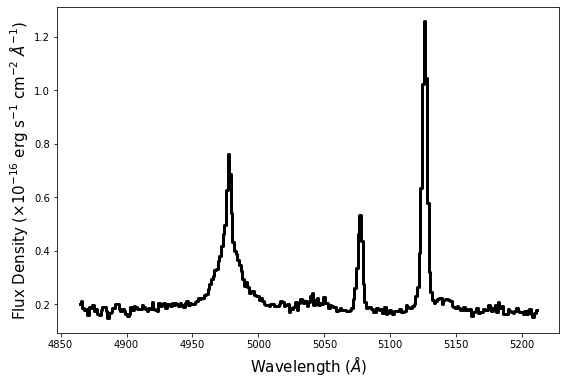

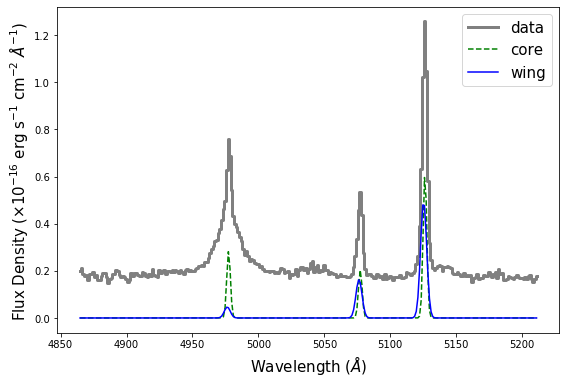

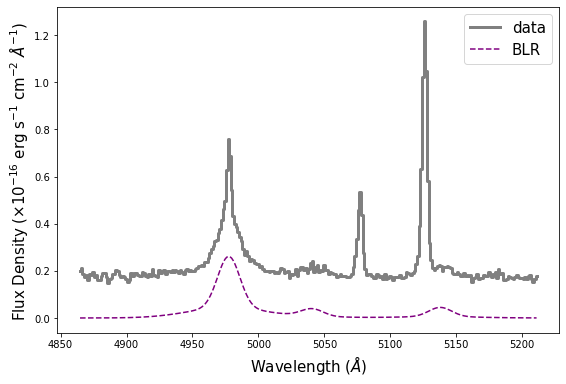

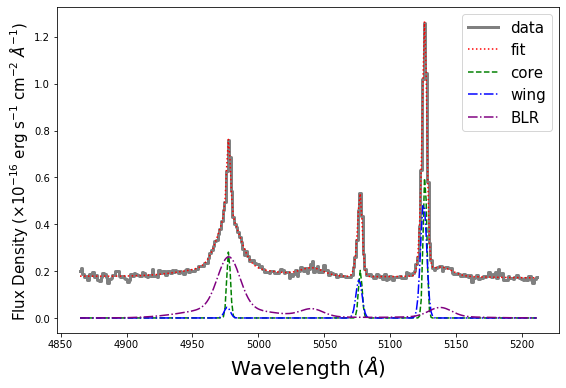

No handles with labels found to put in legend.


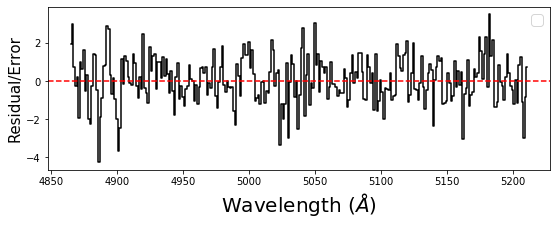

In [14]:
z = {"HE0108-4743":0.02392}

objs = z.keys()

broad2= {'HE0108-4743':True}


p_init= {'HE0108-4743':[1.7,4.5,7160.0,40.0,0.12,2.5,7060.0,120.0,1.0,1.0,6960,1300.0,1.0,1.0,7190,430.0,-0.001,2.0]
}

for obj in objs:
     algorithm_script(obj,p_init[obj],z[obj],broad2[obj]) 
